In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
% matplotlib inline

In [14]:
import gzip
import cPickle


""" Yes, it is 'cutomer' in the dataset and not 'customer'
"""

class Parser:
    def __init__(self):
        self.customer_map = {} 
        self.product_map = {}

    def run(self):
        # self.buildIdMappings()
        self.loadIdMappings()
        #self.buildReviewMatrix()
        self.buildCategoryMatrix()
        self.buildSimilarGraph()

    def buildIdMappings(self, filename='amazon-meta.txt.gz'):
        """Read the file once to map customer ids and product ids to 
        matrix indices. Pickle for next time.
        """
        product_ids = []
        customer_ids = set()

        with gzip.open(filename) as infile:

            for line in infile:
                # track product ID -- should only appear once
                if line.startswith("ASIN:"):
                    asin = line.split()
                    product_ids.append(asin[1])
                # track customer ID 
                if line.find("cutomer:") > -1:
                    review_info = line.split()
                    customer_ids.add(review_info[2])

            # Create map of Amazon customer_id -> Matrix index
            customer_ids = list(customer_ids)
            customer_ids.sort()
            self.customer_map = dict(zip(customer_ids, 
                                range(len(customer_ids))))
    
            # Create map of Amazon product_id -> Matrix index
            self.product_map = dict(zip(product_ids, 
                               range(len(product_ids))))

        # save
        with open('id_maps.pickle', 'w') as map_file:
            cPickle.dump((self.product_map, self.customer_map), map_file)

    def loadIdMappings(self, filename='id_maps.pickle'):
        with open(filename, 'r') as map_file:
            (self.product_map, self.customer_map) = cPickle.load(map_file)
        
    def buildReviewMatrix(self, filename='amazon-meta.txt.gz'):
        with gzip.open(filename) as infile, \
                open('review_matrix.txt', 'w') as outfile:

            product_idx = -1
            for line in infile:
                line = line.strip()

                # product ID
                if line.startswith("ASIN:"):
                    product_idx += 1

                # Reviews
                elif line.find("cutomer:") > -1:
                    review_info = line.split()

                    customer_idx = str(self.customer_map[review_info[2]])
                    rating = review_info[4]
                    votes = review_info[6]
                    helpful = review_info[8]

                    outfile.write('\t'.join([str(product_idx), customer_idx, 
                                             rating, votes, helpful]) + '\n')

    def buildCategoryMatrix(self, filename='amazon-meta.txt.gz'):
        with gzip.open(filename) as infile, \
                open('book_categories.txt', 'w') as outfile:
            
            product_idx = -1
            for line in infile:
                line = line.strip()
                
                # product ID
                if line.startswith('ASIN:'):
                    product_idx += 1
                    
                # categories
                elif line.find("Books[") > -1 and not line.startswith('title'):
                    category = line
                    
                    outfile.write('\t'.join([str(product_idx), category]) + '\n')
    
    def buildSimilarGraph(self, filename='amazon-meta.txt.gz'):
        with gzip.open(filename) as infile, \
                open('similar_products_graph.txt', 'w') as outfile:

            product_idx = -1
            for line in infile:
                line = line.strip()
                
                # product ID
                if line.startswith("ASIN:"):
                    product_idx += 1

                # similar items
                elif line.startswith("similar:"):
                    similar_items = line.split()[2:]
                    for similar in similar_items:
                        if similar in self.product_map:
                            similar_idx = self.product_map[similar]
                            outfile.write('%d\t%d\n' %\
                                              (product_idx, similar_idx))
                

In [15]:
parser = Parser()
parser.run()

## Reviews

In [2]:
reviews = pd.read_csv('review_matrix.txt', delimiter='\t', header=None)
reviews.columns = ['prod_id', 'cust_id', 'rating', 'votes', 'helpful']
reviews.head()

,prod_id,cust_id,rating,votes,helpful
0,1,638190,5,10,9
1,1,769108,5,6,5
2,2,19002,5,5,4
3,2,1251154,4,5,5
4,2,43668,5,8,8


In [9]:
reviews.describe()

,prod_id,cust_id,rating,votes,helpful
count,7.593244e+06,7.593244e+06,7.593244e+06,7.593244e+06,7.593244e+06
mean,2.827273e+05,8.751201e+05,4.178372e+00,5.859097e+00,3.794829e+00
std,1.661600e+05,4.779900e+05,1.250068e+00,1.478179e+01,1.097852e+01
min,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.367350e+05,4.563620e+05,4.000000e+00,1.000000e+00,0.000000e+00
50%,2.775610e+05,9.161660e+05,5.000000e+00,2.000000e+00,1.000000e+00
75%,4.291470e+05,1.324515e+06,5.000000e+00,6.000000e+00,4.000000e+00
max,5.485510e+05,1.555169e+06,5.000000e+00,7.669000e+03,7.453000e+03


In [7]:
prod = reviews.groupby(['prod_id'])[['rating', 'votes', 'helpful']].agg([np.mean, np.std])
prod.head()

rating                votes             helpful          
             mean       std       mean       std      mean       std
prod_id                                                             
1        5.000000  0.000000   8.000000  2.828427  7.000000  2.828427
2        4.333333  1.154701   7.000000  4.067610  6.333333  3.725425
3        5.000000       NaN   2.000000       NaN  2.000000       NaN
4        4.000000       NaN   1.000000       NaN  1.000000       NaN
6        4.235294  1.147247  12.117647  7.372943  8.941176  6.850826

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e189d3d10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7e174f3410>]], dtype=object)

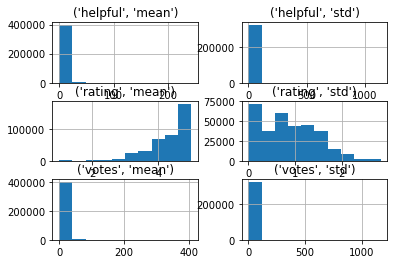

In [8]:
prod.hist()

In [14]:
cond = reviews.helpful > 4  
sum(reviews[cond].prod_id.value_counts().values > 1)

182553

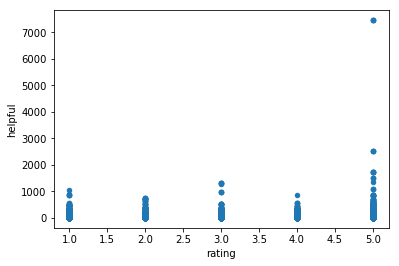

In [17]:
reviews.plot.scatter('rating', 'helpful')

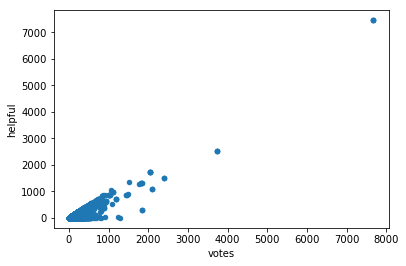

In [18]:
reviews.plot.scatter('votes', 'helpful')

* Ratings are biased towards the ceiling of the scale
* There's a strong, positive linear relationship between the helpful and votes counts for reviews
* Consider removing the votes option, since helpful counts give largely redundant information

## Categories

In [29]:
categories = pd.read_csv('book_categories.txt', delimiter='\t', header=None)
categories.columns = ['prod_id', 'category']
categories.head()

,prod_id,category
0,1,|Books[283155]|Subjects[1000]|Religion & Spiri...
1,1,|Books[283155]|Subjects[1000]|Religion & Spiri...
2,2,|Books[283155]|Subjects[1000]|Religion & Spiri...
3,2,|Books[283155]|Subjects[1000]|Religion & Spiri...
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48...


In [30]:
categories.category.value_counts()

|[265523]|Amazon.com Stores[285080]|Home & Office[764512]|Business & Investing Books[767740]|General[767880]                                                              18439
|Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612]                                                                                                       18437
|Books[283155]|Subjects[1000]|Reference[21]|General[408268]                                                                                                               13703
|Books[283155]|Subjects[1000]|Biographies & Memoirs[2]|General[2375]                                                                                                      12243
|Books[283155]|Subjects[1000]|Nonfiction[53]|Social Sciences[11232]|Sociology[11288]|General[11289]                                                                       11779
|Books[283155]|Subjects[1000]|Literature & Fiction[17]|General[10125]|Contemporary[10129]                               

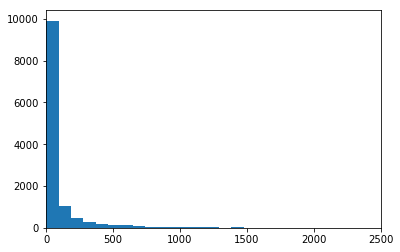

In [31]:
plt.hist(categories.category.value_counts().values, bins=200)
plt.xlim([0, 2500])
plt.show()

In [32]:
categories['cn'] = 1

In [33]:
print categories.shape
categories.head(20)

(1437865, 3)


,prod_id,category,cn
0,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
1,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
2,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
3,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48...,1
5,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
6,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
7,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
8,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1
9,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1


In [34]:
categories.dtypes

prod_id      int64
category    object
cn           int64
dtype: object

In [35]:
categories = categories.join(categories.groupby(['category'])['cn'].sum(), on='category', rsuffix='t')
categories.head()

,prod_id,category,cn,cnt
0,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,367
1,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,318
2,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,490
3,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,527
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48...,1,5108


(0, 2000)

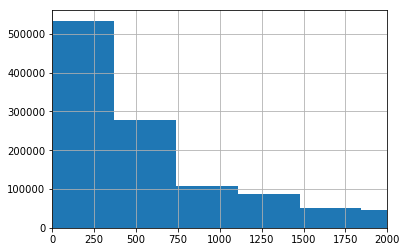

In [7]:
categories.cnt.hist(bins=50)
plt.xlim([0, 2000])

In [22]:
categories[categories.cnt<20].shape[0] / categories.shape[0]

0.0907230986782347

In [21]:
print categories.cnt.quantile([.01, .05, .1])
categories.cnt.describe()

0.01     7.0
0.05    14.0
0.10    20.0
Name: cnt, dtype: float64


count    5.378035e+06
mean     6.199471e+02
std      2.227270e+03
min      1.000000e+00
25%      3.300000e+01
50%      4.700000e+01
75%      5.900000e+01
max      1.843900e+04
Name: cnt, dtype: float64

In [ ]:
eso = categories[categories.cnt<20]

In [38]:
# remove the bottom category for selected esoteric categories
eso['new_cat'] = eso.category.apply(lambda x: ''.join(x.split('|')[:-1]))

/home/jsync/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
eso.head()

,prod_id,category,cn,cnt,new_cat
43,15,|Books[283155]|Subjects[1000]|Literature & Fic...,1,6,Books[283155]Subjects[1000]Literature & Fictio...
70,24,|Books[283155]|Formats[504358]|Books on Tape[4...,1,11,Books[283155]Formats[504358]Books on Tape[44]A...
71,24,|Books[283155]|Formats[504358]|Books on Tape[4...,1,16,Books[283155]Formats[504358]Books on Tape[44]M...
108,33,|Books[283155]|Subjects[1000]|Children's Books...,1,9,Books[283155]Subjects[1000]Children's Books[4]...
165,48,|Books[283155]|Subjects[1000]|Horror[49]|Autho...,1,13,"Books[283155]Subjects[1000]Horror[49]Authors, ..."


In [40]:
categories = categories.merge(eso[['category', 'new_cat']], how='left')

In [41]:
categories.head()

,prod_id,category,cn,cnt,new_cat
0,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,367,NaN
1,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,318,NaN
2,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,490,NaN
3,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,527,NaN
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48...,1,5108,NaN


In [42]:
categories[categories.cnt>20]

,prod_id,category,cn,cnt,new_cat
0,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,367,NaN
1,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,318,NaN
2,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,490,NaN
3,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,527,NaN
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48...,1,5108,NaN
5,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,604,NaN
6,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,343,NaN
7,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,90,NaN
8,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,1782,NaN
9,4,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,2068,NaN


In [43]:
# create cat col with final categories
categories.loc[categories.new_cat.isnull(), 'cat'] = categories[categories.new_cat.isnull()].category

In [44]:
categories.loc[categories.new_cat.notnull(), 'cat'] = categories[categories.new_cat.notnull()].new_cat

In [45]:
categories.head()

,prod_id,category,cn,cnt,new_cat,cat
0,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,367,NaN,|Books[283155]|Subjects[1000]|Religion & Spiri...
1,1,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,318,NaN,|Books[283155]|Subjects[1000]|Religion & Spiri...
2,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,490,NaN,|Books[283155]|Subjects[1000]|Religion & Spiri...
3,2,|Books[283155]|Subjects[1000]|Religion & Spiri...,1,527,NaN,|Books[283155]|Subjects[1000]|Religion & Spiri...
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48...,1,5108,NaN,|Books[283155]|Subjects[1000]|Home & Garden[48...


In [46]:
categories.cat.nunique() / categories.category.nunique()

0.5935004790801661

* Regarding building product categorization, an interesting approach would be to use natural langauge processing.
* For each product type, build a bag of words model based on each items description/specs.
* Then perform agglomerative clustering (to obtain the hierarchy of possible clusters) on that bag of words matrix to determine the category clusters

* Giving users access to items categorization, reviews, and similar items is a good idea as the majority of today's users put a premium on making informed decisions for even the most mundane product purchases. If customers can't get that information from your company, then you're likely to miss out on their business.